Vortex2 es una iteración posterior a Vortex en donde se ha incluido un proceso de remuestreo (SMOTE) y de calibración del modelo antes de guardarlo. Ver [NOTAS](http://localhost:8888/lab/tree/NOTAS.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from ipywidgets import widgets # Interactive functions
from sklearn.metrics import classification_report

In [2]:
#Cargamos el dataset desde nuestro directorio de trabajo
#Working directory
#df = pd.read_csv("DATA/20240812_vortex_trainning_float_formmated.csv", encoding='latin-1') 
df = pd.read_excel('/home/dsg/vortex/PRODUCTION/DATA/raw/20240812_vortex_trainning_float_formmated.xlsx', engine='openpyxl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1816 non-null   object 
 1   Inv. Pieza  1346 non-null   object 
 2   Site        1816 non-null   object 
 3   Contexto    1805 non-null   object 
 4   Contexto 1  0 non-null      float64
 5   Contexto 2  1 non-null      float64
 6   PK_coord    592 non-null    object 
 7   Class       1816 non-null   object 
 8   XRD_code    266 non-null    object 
 9   XRD_path    264 non-null    object 
 10  XRD 1       271 non-null    object 
 11  XRD 2       121 non-null    object 
 12  XRD 3       38 non-null     object 
 13  XRD 4       3 non-null      object 
 14  Group       268 non-null    object 
 15  Subgroup    268 non-null    object 
 16  Hey's CIM   268 non-null    object 
 17  ID_XMET     1814 non-null   object 
 18  Method      1815 non-null   object 
 19  Date XRF    1815 non-null  

In [3]:
# Eliminamos columnas innecesarias para nuestro experimiento
#Some basic Feature engineering
data = df.drop(df.iloc[:, : 22], axis=1)
#Comprobamos que no hay valores faltantes
# Checking missing values
data.isnull().any().any()


False

In [8]:
#data = data.drop(['suma'], axis=1)
data['Site'] = df['Site']
data['id'] = df['ID']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1816 non-null   float64
 1   Si      1816 non-null   float64
 2   P       1816 non-null   float64
 3   S       1816 non-null   float64
 4   Cl      1816 non-null   float64
 5   K       1816 non-null   float64
 6   Ca      1816 non-null   float64
 7   Sc      1816 non-null   float64
 8   Ti      1816 non-null   float64
 9   V       1816 non-null   float64
 10  Cr      1816 non-null   float64
 11  Mn      1816 non-null   float64
 12  Fe      1816 non-null   float64
 13  Co      1816 non-null   float64
 14  Ni      1816 non-null   float64
 15  Cu      1816 non-null   float64
 16  Zn      1816 non-null   float64
 17  Ga      1816 non-null   float64
 18  Ge      1816 non-null   float64
 19  As      1816 non-null   float64
 20  Se      1816 non-null   float64
 21  Br      1816 non-null   float64
 22  

In [9]:
# 1. Comprobar si hay duplicados
duplicados = data['id'].duplicated().sum()
print(f"Número de ids duplicados: {duplicados}")

# 2. Ver los ids duplicados (si existen)
if duplicados > 0:
    print("IDs duplicados:")
    print(data[data['id'].duplicated(keep=False)]['id'].sort_values())

# 3. Eliminar duplicados, manteniendo la primera aparición
data_sin_duplicados = data.drop_duplicates(subset='id', keep='first')

# 4. Verificar que se eliminaron los duplicados
print(f"Tamaño original de data: {data.shape}")
print(f"Tamaño de data sin duplicados: {data_sin_duplicados.shape}")

# 5. Comprobar nuevamente que no hay duplicados
duplicados_restantes = data_sin_duplicados['id'].duplicated().sum()
print(f"Número de ids duplicados restantes: {duplicados_restantes}")

# 6. Si estás satisfecho con el resultado, puedes asignar el resultado de vuelta a 'data'
data = data_sin_duplicados

# 7. Reiniciar los índices si es necesario
data.reset_index(drop=True, inplace=True)

Número de ids duplicados: 14
IDs duplicados:
1094                    G-84-218
1093                    G-84-218
1178                     G-85-80
1179                     G-85-80
392               GEOLOGICA LEON
393               GEOLOGICA LEON
394               GEOLOGICA LEON
395               GEOLOGICA LEON
396     GEOLOGICA QUINTANA MARCO
397     GEOLOGICA QUINTANA MARCO
440            PCM2/10/A/4-41-10
893            PCM2/10/A/4-41-10
441            PCM2/10/A/4-41-11
894            PCM2/10/A/4-41-11
897           PCM2/10/E/SUP-25-8
759           PCM2/10/E/SUP-25-8
672            PCM2/10/SUP-36-11
760            PCM2/10/SUP-36-11
899            PCM2/10/SUP-36-18
674            PCM2/10/SUP-36-18
900            PCM2/10/SUP-36-24
675            PCM2/10/SUP-36-24
677            PCM2/10/SUP-36-30
901            PCM2/10/SUP-36-30
902                       SC2-29
1794                      SC2-29
Name: id, dtype: object
Tamaño original de data: (1816, 46)
Tamaño de data sin duplicados: (1802,

In [10]:
data.id.nunique()

1802

We will create a random feature to be used as a threshold for choosing important features later on.

In [11]:
data['rand'] = np.random.normal(loc=30, scale=1.5, size=1802)

# Limitar los valores entre 0.70 y 59.0
data['rand'] = data['rand'].clip(lower=0.70, upper=59.0)

In [12]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1802 non-null   float64
 1   Si      1802 non-null   float64
 2   P       1802 non-null   float64
 3   S       1802 non-null   float64
 4   Cl      1802 non-null   float64
 5   K       1802 non-null   float64
 6   Ca      1802 non-null   float64
 7   Sc      1802 non-null   float64
 8   Ti      1802 non-null   float64
 9   V       1802 non-null   float64
 10  Cr      1802 non-null   float64
 11  Mn      1802 non-null   float64
 12  Fe      1802 non-null   float64
 13  Co      1802 non-null   float64
 14  Ni      1802 non-null   float64
 15  Cu      1802 non-null   float64
 16  Zn      1802 non-null   float64
 17  Ga      1802 non-null   float64
 18  Ge      1802 non-null   float64
 19  As      1802 non-null   float64
 20  Se      1802 non-null   float64
 21  Br      1802 non-null   float64
 22  

Index(['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Rb', 'Sr',
       'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
       'Ba', 'Ta', 'W', 'Au', 'Hg', 'Tl', 'Pb', 'Th', 'Site', 'id', 'rand'],
      dtype='object')

In [13]:
# Distribución en el target
target = data['Site'].value_counts()
target

CT                     828
PDLC                   511
PCM                    439
SX                       9
MINA TURQUESA/COBRE      9
SARRABUS                 3
LEON                     1
QUINTANA MARCO           1
Zamora                   1
Name: Site, dtype: int64

In [14]:
# Eliminación de casos. Clases <10 para el target_Group
# Case deletion for classes >10
casos = target[target <10]
values = casos.index
values
deleted_cases= data[data['Site'].isin(values)]
case_del = deleted_cases.index
data.drop(case_del, inplace=True)

In [15]:
data['Site'].value_counts()

CT      828
PDLC    511
PCM     439
Name: Site, dtype: int64

In [ ]:
data.to_excel('./DATA/FinalTrainingData.xlsx')

In [16]:
# Validation set 1 (VS1)
data_trainning = data.sample(frac=0.90, random_state=786)
vs1 = data.drop(data_trainning.index)
data_trainning.reset_index(inplace=True, drop=True)
vs1.reset_index(inplace=True, drop=True)
print('Data for further procedures: ' + str(data_trainning.shape))
print('Data for final validation: ' + str(vs1.shape))
#vs1.to_csv('./TABLES/validation_set1.csv')

Data for further procedures: (1600, 47)
Data for final validation: (178, 47)


In [ ]:
vs1.to_csv('./DATA/FVS.csv')

In [ ]:
vs1.Site.value_counts()

In [ ]:
data_trainning.Site.value_counts()

#### Creating our Classification function:


In [17]:
X = data_trainning.drop(['Site', 'id'], axis=1)
y = data_trainning['Site']

In [ ]:
y.value_counts()

#### Data Aumentagtion of minority classes (SMOTE)
We carry out the Synthetic Minority Oversampling Technique

PDLC    752
CT      752
PCM     752
Name: Site, dtype: int64

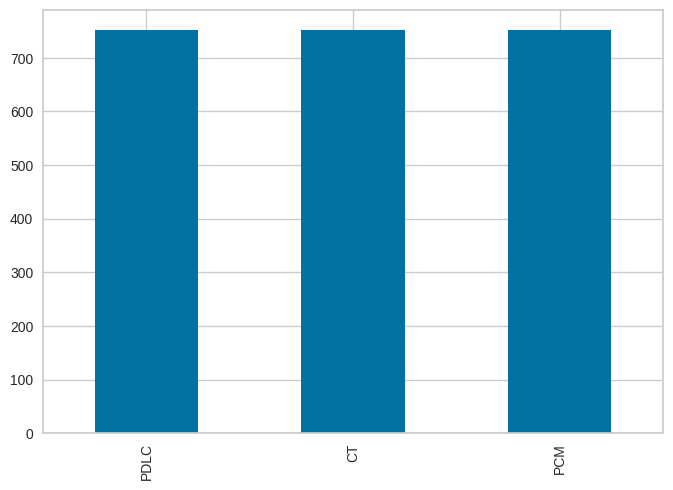

In [18]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

#### We have created a balanced synthetic data set with 752 cases per class.

In [19]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [20]:
# Final dataset shape after resampling
smote_data.shape
smote_data.to_excel('./DATA/20241011FinalResampledTrainingDataset.xlsx')
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      2256 non-null   float64
 1   Si      2256 non-null   float64
 2   P       2256 non-null   float64
 3   S       2256 non-null   float64
 4   Cl      2256 non-null   float64
 5   K       2256 non-null   float64
 6   Ca      2256 non-null   float64
 7   Sc      2256 non-null   float64
 8   Ti      2256 non-null   float64
 9   V       2256 non-null   float64
 10  Cr      2256 non-null   float64
 11  Mn      2256 non-null   float64
 12  Fe      2256 non-null   float64
 13  Co      2256 non-null   float64
 14  Ni      2256 non-null   float64
 15  Cu      2256 non-null   float64
 16  Zn      2256 non-null   float64
 17  Ga      2256 non-null   float64
 18  Ge      2256 non-null   float64
 19  As      2256 non-null   float64
 20  Se      2256 non-null   float64
 21  Br      2256 non-null   float64
 22  

In [21]:
# Experiment setup 

experiment = setup(data=smote_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2256, 46)"
5,Transformed data shape,"(2256, 46)"
6,Transformed train set shape,"(1804, 46)"
7,Transformed test set shape,"(452, 46)"
8,Numeric features,45
9,Preprocess,True


In [22]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [23]:
rf = create_model('rf', class_weight="balanced", criterion='entropy')

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9834,0.9834,0.9842,0.9834
1,0.9613,0.9613,0.9626,0.9614
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9611,0.9611,0.9611,0.9611
5,0.9778,0.9778,0.9785,0.9778
6,0.9722,0.9722,0.9726,0.9722
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9619,0.9611


In [24]:
tuned_model = tune_model(rf, n_iter=10, tuner_verbose=True, optimize='F1', custom_grid = {'criterion': ['entropy']})

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9834,0.9834,0.9842,0.9834
1,0.9613,0.9613,0.9626,0.9614
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9611,0.9611,0.9611,0.9611
5,0.9778,0.9778,0.9785,0.9778
6,0.9722,0.9722,0.9726,0.9722
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9619,0.9611


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Calculating feature importance

In [ ]:
#plot_model(tuned_model, plot='feature', plot_kwargs = {'encoder' : get_config('pipeline').steps[0][1].transformer}, save=True)

In [ ]:
stop

In [25]:
training_data = get_config('X_train')
y_training= get_config('y_train')
training_data['Site'] = y_training
y_training

1479      CT
335      PCM
1249    PDLC
728      PCM
1835     PCM
        ... 
1726     PCM
875       CT
286       CT
1106     PCM
396       CT
Name: Site, Length: 1804, dtype: category
Categories (3, object): ['CT', 'PCM', 'PDLC']

In [26]:
train = get_config('X_train')
train.columns

Index(['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Rb', 'Sr',
       'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
       'Ba', 'Ta', 'W', 'Au', 'Hg', 'Tl', 'Pb', 'Th', 'rand'],
      dtype='object')

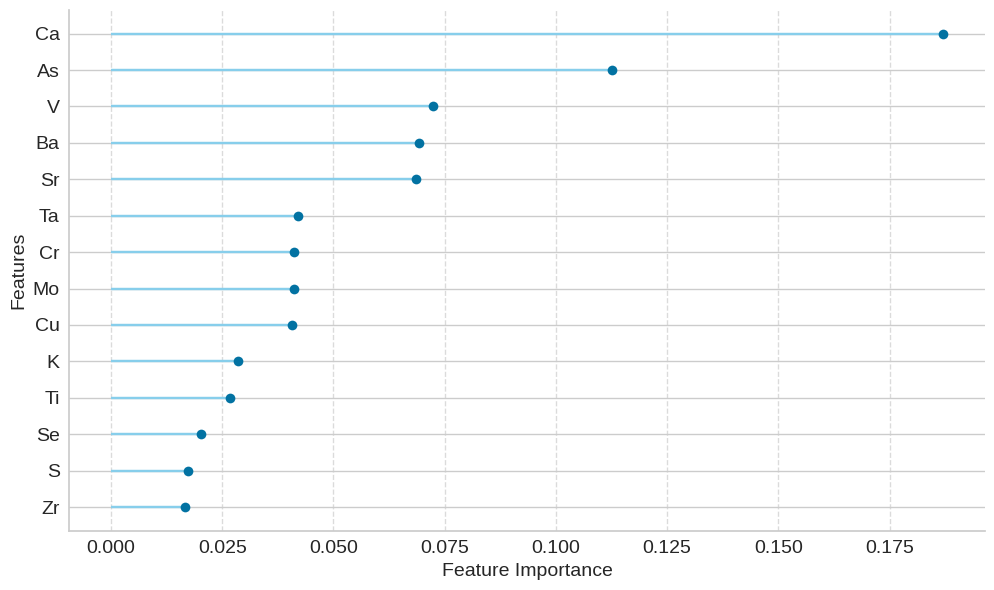

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_names = train.columns
def plot_feature_importance_dotplot(model, feature_names=None, n_features=10):
    # Obtener la importancia de las características
    importances = model.feature_importances_
    
    # Si no se proporcionan nombres de características, usar índices
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    
    # Crear un DataFrame con las características y sus importancias
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Ordenar el DataFrame por importancia descendente
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    # Limitar el número de características a visualizar
    feature_importance_df = feature_importance_df.head(n_features)
    
    # Crear el gráfico de puntos
    fig, ax = plt.subplots(figsize=(10, max(6, n_features * 0.3)))
    
    # Dibujar líneas horizontales
    ax.hlines(y=range(n_features), xmin=0, xmax=feature_importance_df['importance'], color='skyblue')
    
    # Dibujar puntos
    ax.plot(feature_importance_df['importance'], range(n_features), "o")
    
    # Configurar el eje y
    ax.set_yticks(range(n_features),)
    ax.set_yticklabels(feature_importance_df['feature'])
    ax.invert_yaxis()  # Las características más importantes arriba
    
   
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Features')
    # Añadir título y ajustar diseño
    #ax.set_title('Feature Importance Plot')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.savefig('./FIGURES/20250126feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()



# Ejemplo de uso:
# Asumiendo que ya tiene su modelo entrenado llamado 'rf_model' y una lista de nombres de características 'feature_names'
plot_feature_importance_dotplot(tuned_model, feature_names, n_features=14)

In [28]:
names= rf.classes_
names

array([0, 1, 2])

In [29]:
test_data = get_config('X_test')
y_test= get_config('y_test')
test_data['Site'] = y_test

In [ ]:
training_data.info()

In [ ]:
#training_data.to_excel('./DATA/Vortex2TrainingData.xlsx')

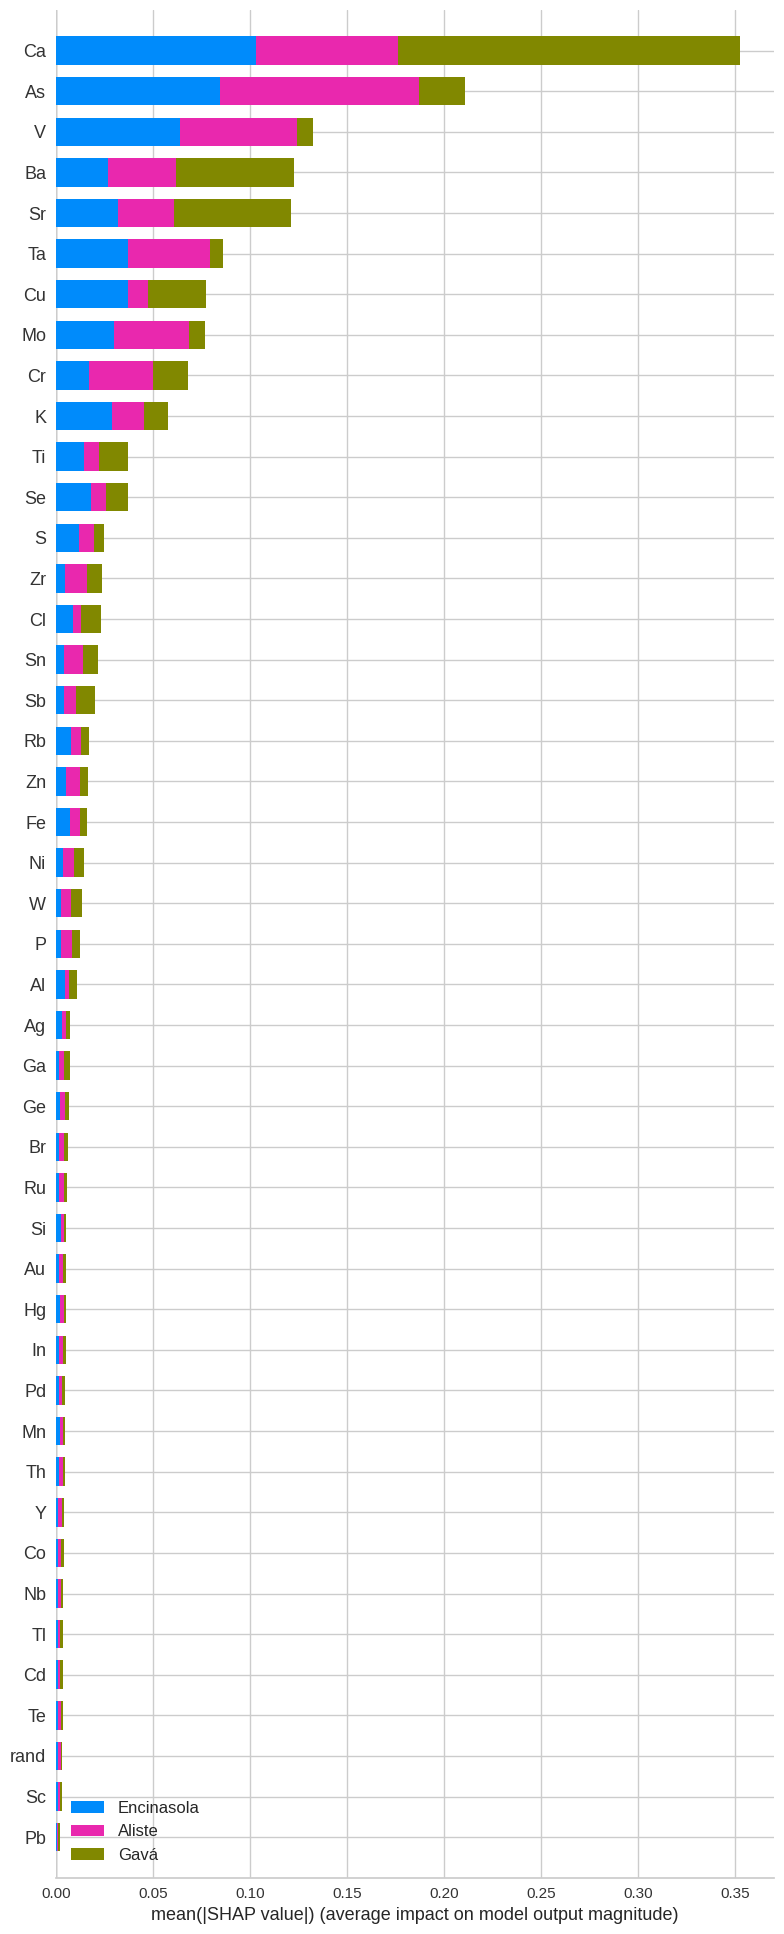

In [30]:
%matplotlib inline
interpret_model(tuned_model, class_names=['Gavá', 'Encinasola', 'Aliste'],max_display= 46)#, cmap='OrId', , max_display= 14)#, save=True)#rf.classes_)#,save=True)


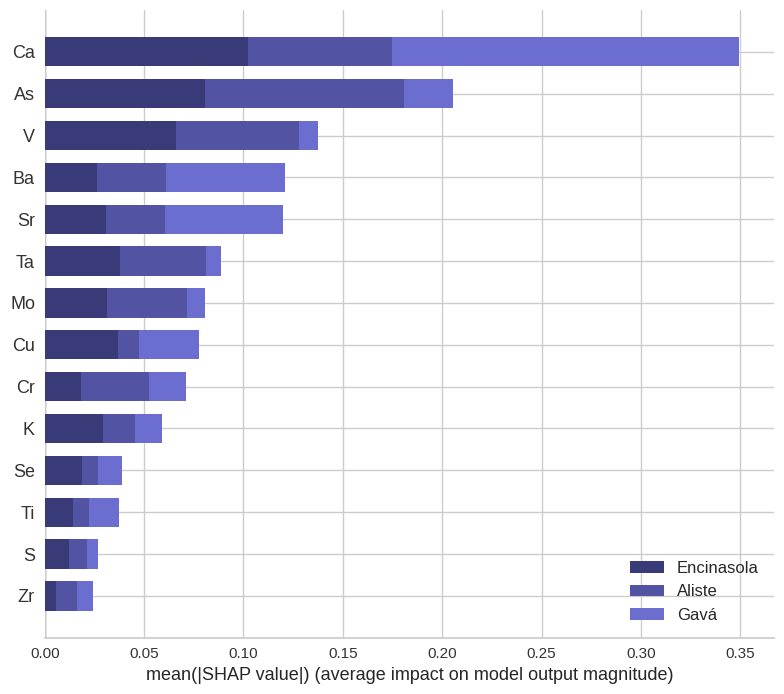

In [31]:

import shap
import matplotlib.pyplot as plt
X_train = get_config(variable="X_train")
def custom_interpret_model(model, X_train, plot='summary', feature_name=None, observation=None, 
                           use_train_data=True, X_new_sample=None, colormap='cividis', 
                           class_names=None, max_display=None):
    
    # Obtener el objeto de explicación SHAP
    explainer = shap.TreeExplainer(model)
    
    # Usar X_train si use_train_data es True, de lo contrario usar X_new_sample si se proporciona
    if use_train_data:
        data_for_shap = X_train
    elif X_new_sample is not None:
        data_for_shap = X_new_sample
    else:
        raise ValueError("Debe proporcionar X_new_sample si use_train_data es False")

    shap_values = explainer.shap_values(data_for_shap)

    # Crear una nueva figura
    plt.figure(figsize=(10, 8))

    # Generar el summary plot con la paleta de colores personalizada
    shap.summary_plot(shap_values, 
                      data_for_shap,
                      plot_type="bar",
                      class_names=class_names,
                      color=plt.get_cmap(colormap),
                      max_display=max_display)

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso de la función
# Asumiendo que ya tiene su modelo entrenado y sus datos de entrenamiento
custom_interpret_model(tuned_model, 
                        X_train,  # Sus datos de entrenamiento
                        class_names=['Gavá', 'Encinasola', 'Aliste'], 
                        max_display=14, 
                        colormap= 'tab20b')

In [39]:
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

def custom_interpret_model(model, X_train, plot='summary', feature_name=None, observation=None, 
                           use_train_data=True, X_new_sample=None, class_names=None, max_display=14):
    
    explainer = shap.TreeExplainer(model)
    
    if use_train_data:
        data_for_shap = X_train
    elif X_new_sample is not None:
        data_for_shap = X_new_sample
    else:
        raise ValueError("Debe proporcionar X_new_sample si use_train_data es False")
        
    shap_values = explainer.shap_values(data_for_shap)
    
    # Asegurar que el directorio existe
    os.makedirs("./FIGURES", exist_ok=True)
    
    # Crear figura explícitamente
    fig = plt.figure(figsize=(10, 8))
    
    colors = [(0.6, 0.6, 0.6), (0.1, 0.1, 0.1)]
    gray_cmap = LinearSegmentedColormap.from_list("custom_grays", colors, N=3)
    
    # Guardar el plot actual
    ax = plt.gca()
    
    # Generar el plot
    shap.summary_plot(shap_values, 
                     data_for_shap,
                     plot_type="bar",
                     class_names=class_names,
                     color=gray_cmap,
                     max_display=max_display,
                     show=False)  # Importante: no mostrar aún
    
    # Guardar y limpiar
    plt.savefig("./FIGURES/20250126_SHAPSummaryGray.tiff", dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Mostrar el plot
    plt.show()

# Uso
custom_interpret_model(tuned_model, 
                      X_train,
                      class_names=['Gavá', 'Encinasola', 'Aliste'])

In [ ]:
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def custom_interpret_model(model, X_train, plot='summary', feature_name=None, observation=None, 
                           use_train_data=True, X_new_sample=None, class_names=None, max_display=None,
                           save_path=None):
    
    # Obtener el objeto de explicación SHAP
    explainer = shap.TreeExplainer(model)
    
    # Usar X_train si use_train_data es True, de lo contrario usar X_new_sample si se proporciona
    if use_train_data:
        data_for_shap = X_train
    elif X_new_sample is not None:
        data_for_shap = X_new_sample
    else:
        raise ValueError("Debe proporcionar X_new_sample si use_train_data es False")

    shap_values = explainer.shap_values(data_for_shap)

    # Crear una nueva figura
    plt.figure(figsize=(10, 8))

    # Crear una paleta secuencial de grises personalizada
    colors = [(0.6, 0.6, 0.6), (0.1, 0.1, 0.1)]  # Del gris claro al gris oscuro
    n_bins = 3  # Número de tonos de gris
    gray_cmap = LinearSegmentedColormap.from_list("custom_grays", colors, N=n_bins)

    # Generar el summary plot con la paleta de grises personalizada
    shap.summary_plot(shap_values, 
                      data_for_shap,
                      plot_type="bar",
                      class_names=class_names,
                      color=gray_cmap,
                      max_display=max_display,
                      show=False)  # No mostrar el gráfico inmediatamente

    # Ajustar el diseño
    plt.tight_layout()

    # Guardar o mostrar el gráfico
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()  # Cerrar la figura para liberar memoria
        print(f"Gráfico guardado en: {save_path}")
    else:
        plt.show()

# Ejemplo de uso de la función
custom_interpret_model(tuned_model, 
                        X_train,  # Sus datos de entrenamiento
                        class_names=['Gavá', 'Encinasola', 'Aliste'], 
                        max_display=14,
                        save_path='./FIGURES/20241017_SHAPSummaryBlackGray.eps')

In [40]:
tuned_model_score_grid = pull()
#tuned_model_score_grid.to_csv('./TABLES/20240814_tunedClassifierScore.csv')
tuned_model_score_grid

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9834,0.9834,0.9842,0.9834
1,0.9613,0.9613,0.9626,0.9614
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9611,0.9611,0.9611,0.9611
5,0.9778,0.9778,0.9785,0.9778
6,0.9722,0.9722,0.9726,0.9722
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9619,0.9611


In [41]:
predict_model(tuned_model);

,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9712,0.9712,0.9716,0.9712


### Model Calibration:
This function calibrates the probability of a given estimator using isotonic or logistic regression. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.
We chose this method to take into account the following library documentation [warning](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.calibrate_model) and avoid overfitting. 


In [42]:
cal_model = calibrate_model(tuned_model)
cal_model

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9779,0.9779,0.9782,0.9779
1,0.9503,0.9503,0.9511,0.9504
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9500,0.9500,0.9503,0.9501
5,0.9611,0.9611,0.9624,0.9612
6,0.9722,0.9722,0.9726,0.9722
7,0.9722,0.9722,0.9726,0.9722
8,0.9667,0.9667,0.9667,0.9666


CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        monotonic_cst=None,
                                                        n_estimators=100,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=123,
                                                        verbose=0,
                                                        warm_start=False),
                       method='sigmoid', n_jobs=None)

In [43]:
X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

PCM     151
PDLC    151
CT      150
Name: Site, dtype: int64

In [ ]:
stop


In [ ]:
#The calibrated model evaluated against test data
last_training_predictions = predict_model(cal_model)

y_true = y_test
y_pred = last_training_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep.to_csv('./TABLES/20240823_classificationReportTestData.csv')
class_rep


In [44]:
#Eliminación recursiva de variables usando validación cruzada:  https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


rvcdf = training_data  

# Separar características (X) y variable objetivo (y)
X = rvcdf.drop(['Site', 'rand'], axis=1)
y = rvcdf['Site']
rvcdf['Site'].value_counts()

CT      602
PCM     601
PDLC    601
Name: Site, dtype: int64

In [ ]:
X.columns

We have used a recursive variable elimination procedure to establish the optimal number of variables necessary for the development of the classification. More details in [NOTAS](http://localhost:8888/lab/tree/NOTAS.ipynb)20240908 note

In [45]:
# Create the RFE object and compute a cross-validated score.
#svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rfecv = RFECV(estimator=tuned_model, step=1, cv=cv,
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)


Optimal number of features : 44


In [ ]:
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from collections import Counter
# Assume X is your feature matrix and feature_names is a list of your feature names
# If you don't have feature_names, you can create them like this:
#feature_names = [f"feature_{i}" for i in range(X.shape[1])]
feature_names = X.columns
def run_rfecv(X, y, tuned_model, random_state):
    np.random.seed(random_state)  # Set seed for any numpy operations
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    rfecv = RFECV(estimator=clone(tuned_model), step=2, cv=cv, scoring='accuracy')
    rfecv.fit(X, y)
    
    # Handle different scikit-learn versions
    if hasattr(rfecv, 'cv_results_'):
        # For newer scikit-learn versions
        grid_scores = rfecv.cv_results_['mean_test_score']
    elif hasattr(rfecv, 'grid_scores_'):
        # For older scikit-learn versions
        grid_scores = rfecv.grid_scores_
    else:
        raise AttributeError("RFECV object has neither 'cv_results_' nor 'grid_scores_' attribute")
    
    # Get the mask of selected features
    feature_mask = rfecv.support_
    
    return rfecv.n_features_, grid_scores, feature_mask

# Number of times to run the process
n_runs = 10

# Lists to store results
n_features_list = []
grid_scores_list = []
feature_masks = []

# Run the process multiple times
for i in range(n_runs):
    n_features, grid_scores, feature_mask = run_rfecv(X, y, tuned_model, random_state=i)
    n_features_list.append(n_features)
    grid_scores_list.append(grid_scores)
    feature_masks.append(feature_mask)

# Calculate average and variance of optimal number of features
avg_n_features = np.mean(n_features_list)
var_n_features = np.var(n_features_list)

print(f"Average optimal number of features: {avg_n_features:.2f}")
print(f"Variance in optimal number of features: {var_n_features:.2f}")

# Calculate average and variance of grid scores
avg_grid_scores = np.mean(grid_scores_list, axis=0)
var_grid_scores = np.var(grid_scores_list, axis=0)


# Print the range of optimal features
min_features = min(n_features_list)
max_features = max(n_features_list)
print(f"Range of optimal number of features: {min_features} to {max_features}")
feature_selection_counts = Counter()
for mask in feature_masks:
    feature_selection_counts.update(np.where(mask)[0])

total_runs = len(feature_masks)
consistent_features = [feature for feature, count in feature_selection_counts.items() 
                       if count == total_runs]
mostly_consistent_features = [feature for feature, count in feature_selection_counts.items() 
                              if count >= total_runs * 0.8]

# Map indices to feature names
consistent_feature_names = [feature_names[i] for i in consistent_features]
mostly_consistent_feature_names = [feature_names[i] for i in mostly_consistent_features]

print("\nFeatures selected in all runs:")
for idx, name in zip(consistent_features, consistent_feature_names):
    print(f"Index {idx}: {name}")

print("\nFeatures selected in at least 80% of runs:")
for idx, name in zip(mostly_consistent_features, mostly_consistent_feature_names):
    print(f"Index {idx}: {name}")



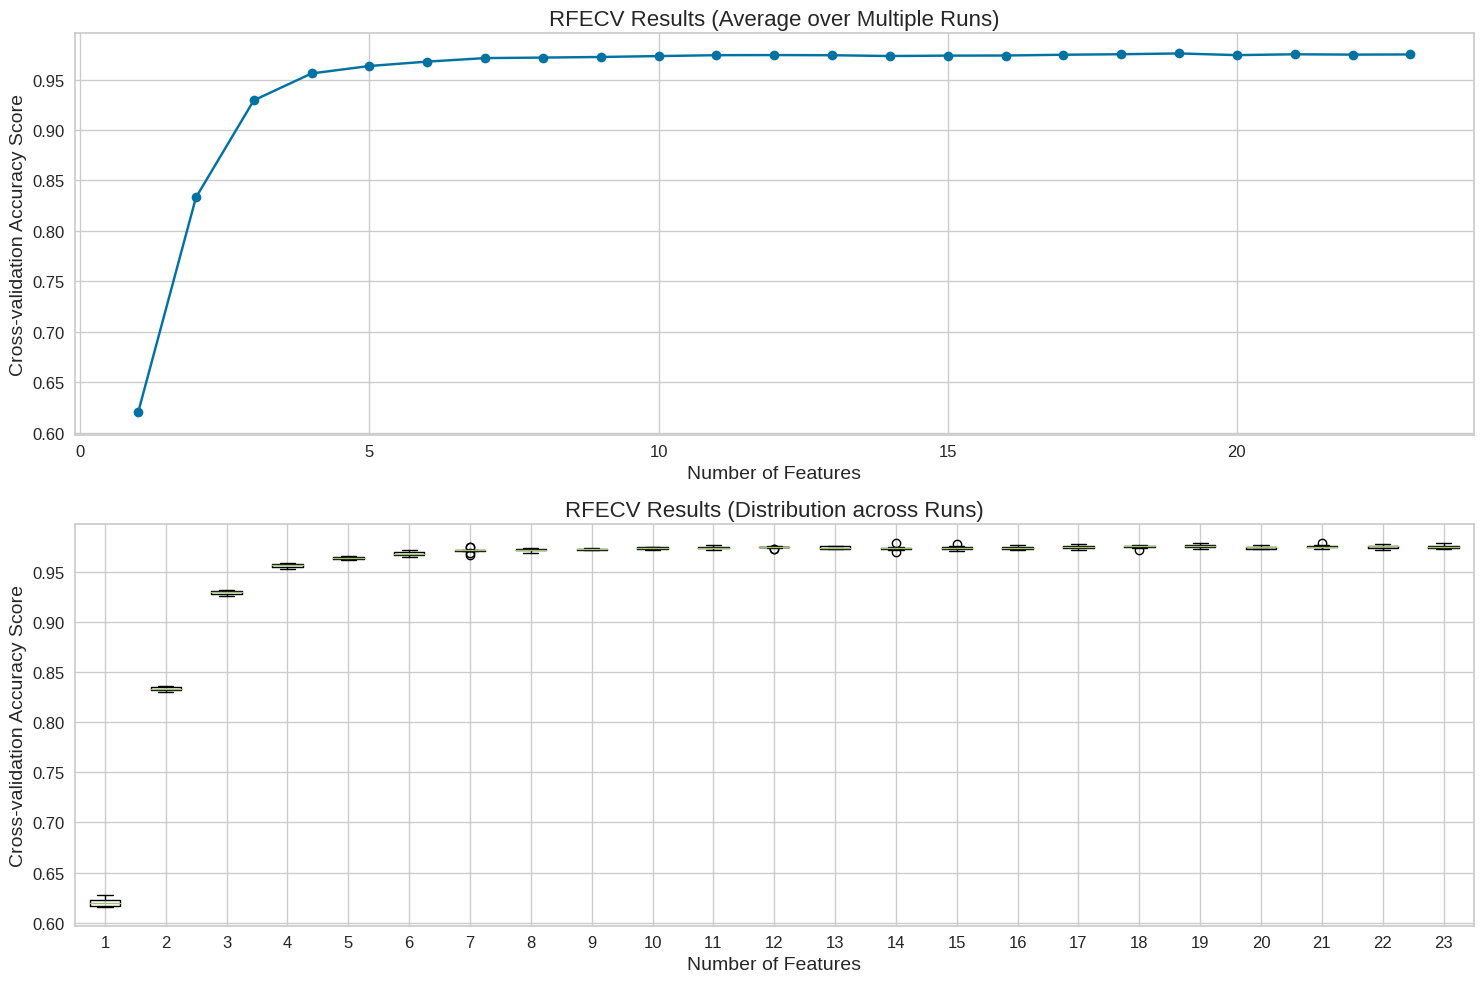

In [50]:


# Modificación en la parte de visualización
plt.figure(figsize=(15, 10))

# Subplot para el gráfico de líneas original
plt.subplot(2, 1, 1)
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-')
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('RFECV Results (Average over Multiple Runs)', fontsize=16)

# Subplot para el boxplot
plt.subplot(2, 1, 2)
# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))
plt.boxplot(grid_scores_transposed)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(range(1, len(grid_scores_transposed) + 1), range(1, len(grid_scores_transposed) + 1), fontsize=12)
plt.title('RFECV Results (Distribution across Runs)', fontsize=16)

plt.savefig("./FIGURES/20250126RFECV_with_boxplot.tiff", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
#plt.savefig("./FIGURES/20250126RFECV_with_boxplot.png", dpi=300, bbox_inches='tight')

In [ ]:


# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
plt.figure(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
bp = plt.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
                 widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
for box in bp['boxes']:
    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Superponer la línea de promedios con barras de error
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='ro-', ecolor='black', 
             capsize=5, capthick=2, linewidth=2, markersize=8)

# Configurar el gráfico
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.title('RFECV Results: Average and Distribution Across Runs', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(range(1, len(avg_grid_scores) + 1), range(1, len(avg_grid_scores) + 1), fontsize=12)

# Añadir una leyenda
plt.plot([], [], 'ro-', linestyle='--',alpha=0.7, label='Average Score')
plt.plot([], [], 'b-', label='Median Score')
plt.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
# plt.savefig("./FIGURES/20240916RFECV_combined.png", dpi=300, bbox_inches='tight')

In [ ]:


# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
plt.figure(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
bp = plt.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
                 widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
for box in bp['boxes']:
    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Superponer la línea de promedios con barras de error
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-', ecolor='darkgray', 
             color='gray', capsize=3, capthick=1, linewidth=1, markersize=4, alpha=0.7)

# Configurar el gráfico
plt.xlabel('Number of Features', fontsize=16)
plt.ylabel('Cross-validation Accuracy Score', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(range(1, len(avg_grid_scores) + 1), range(1, len(avg_grid_scores) + 1), fontsize=14)

# Añadir una leyenda
plt.plot([], [], 'o-', color='gray', alpha=0.7, linewidth=1, markersize=4, label='Average Score')

plt.legend(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
#plt.savefig("./FIGURES/20240920RFECV_boxplot.jpg")

In [ ]:


# Importar el backend de Matplotlib
import matplotlib
#matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
#bp = ax.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
#                widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
#for box in bp['boxes']:
#    box.set(edgecolor='gray', alpha=0.7)

# Superponer la línea de promedios con barras de error
#ax.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
#            yerr=np.sqrt(var_grid_scores), fmt='o-', ecolor='darkgray', 
#            color='gray', capsize=3, capthick=1, linewidth=1, markersize=4, alpha=0.7)

# Configurar el gráfico
ax.set_xlabel('Number of Features', fontsize=16)
ax.set_ylabel('Cross-validation Accuracy Score', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.plot([], [], 'o-', color='gray', alpha=0.7, linewidth=1, markersize=4, label='Average Score')
#ax.plot([], [], 'b-', label='Median Score')
#ax.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
ax.legend(fontsize=14)

ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()

# Guardar la figura
#plt.savefig("./FIGURES/20240921RFECV_refined.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
#plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-')

#plt.title('RFECV Results (Average over Multiple Runs)')
plt.xlabel('Number of Features',fontsize=18)
plt.ylabel('Cross-validation Accuracy Score',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.savefig("./FIGURES/20240916RFECV.png",dpi=300, bbox_inches='tight')
plt.show()


# Optional: Create a bar plot of feature importance
plt.figure(figsize=(12, 6))
feature_importance = [feature_selection_counts[i] / total_runs for i in range(len(feature_names))]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(feature_importance))
plt.barh(pos, [feature_importance[i] for i in sorted_idx])
plt.yticks(pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance (Fraction of Runs Selected)')
plt.title('Feature Importance Across Multiple Runs')
plt.tight_layout()
plt.show()


20241001

Probando visualizar con una region sombreada en lugar de barras de error

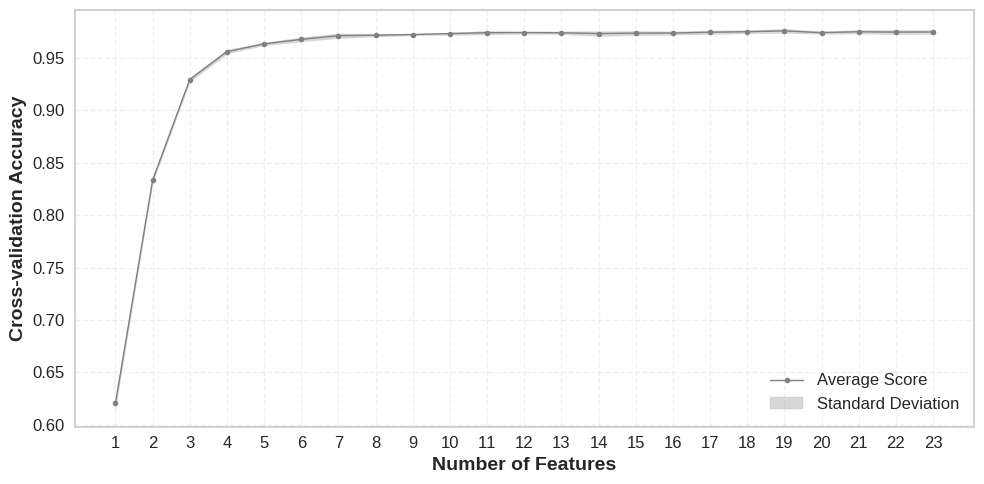

In [57]:

# Importar el backend de Matplotlib
import matplotlib
#matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(10, 5))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
#bp = ax.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
#                widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
#for box in bp['boxes']:
#    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Calcular los límites superior e inferior para la región sombreada
x = range(1, len(avg_grid_scores) + 1)
lower_bound = avg_grid_scores - np.sqrt(var_grid_scores)
upper_bound = avg_grid_scores + np.sqrt(var_grid_scores)

# Dibujar la región sombreada
ax.fill_between(x, lower_bound, upper_bound, color='gray', alpha=0.3)

# Dibujar la línea de promedios
ax.plot(x, avg_grid_scores, 'o-', color='gray', linewidth=1, markersize=4)

# Configurar el gráfico
ax.set_xlabel('Number of Features',fontweight='bold', fontsize=14)
ax.set_ylabel('Cross-validation Accuracy',fontweight='bold', fontsize=14)
#ax.set_title('RFECV Results: Distribution and Average Across Runs', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.plot([], [], 'o-', color='gray', linewidth=1, markersize=4, label='Average Score')
ax.fill([], [], color='gray', alpha=0.3, label='Standard Deviation')
#ax.plot([], [], 'b-', label='Median Score')
#ax.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
ax.legend(fontsize=12)

ax.grid(True, linestyle='--', alpha=0.3)

fig.tight_layout()

# Guardar la figura
plt.savefig("./FIGURES/20250126RFECV_refined_shaded_only.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
#plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
plt.show()

In [ ]:
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from collections import Counter
# Importar el backend de Matplotlib
import matplotlib
matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Calcular los cuartiles para cada número de características
lower_quartiles = [np.percentile(scores, 25) for scores in grid_scores_transposed]
medians = [np.median(scores) for scores in grid_scores_transposed]
upper_quartiles = [np.percentile(scores, 75) for scores in grid_scores_transposed]

# Calcular los límites para el área sombreada
x = range(1, len(avg_grid_scores) + 1)
lower_bound = lower_quartiles
upper_bound = upper_quartiles

# Dibujar el área sombreada (reemplazando los boxplots)
ax.fill_between(x, lower_bound, upper_bound, color='lightblue', alpha=0.7)

# Dibujar la línea de medianas
ax.plot(x, medians, '-', color='blue', linewidth=0.7, label='Median Score')

# Dibujar la línea de promedios
ax.plot(x, avg_grid_scores, 'o-', color='grey', linewidth=0.5, markersize=2, label='Average Score')

# Configurar el gráfico
ax.set_xlabel('Number of Features', fontsize=14)
ax.set_ylabel('Cross-validation Accuracy Score', fontsize=14)
ax.set_title('RFECV Results: Distribution and Average Across Runs', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.fill([], [], color='lightblue', alpha=0.7, label='IQR (25th to 75th percentile)')
ax.legend(fontsize=12)

ax.grid(True, linestyle='--', alpha=0.3)
fig.tight_layout()

# Guardar la figura
plt.savefig("./FIGURES/20241001RFECV_refined_shaded_boxplots2.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
# plt.show()

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.axhline(y=0.949, color='red', linestyle='--', label='Full model performance')
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

# Para ver las características seleccionadas:
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

In [ ]:
#dashboard(tuned_model)

In [ ]:
final_model = finalize_model(cal_model)


In [ ]:
unseen_predictions = predict_model(final_model, data=vs1)

#x = unseen_predictions['Site'] == unseen_predictions['Label']
#unseen_predictions['error'] = x


unseen_predictions

In [ ]:
y_true_vs1 = unseen_predictions['Site']
y_pred_vs1 = unseen_predictions['prediction_label']
class_rep_vs1 = pd.DataFrame(classification_report(y_true_vs1, y_pred_vs1, output_dict=True)).T
#class_rep_vs1.to_csv('./TABLES/20240826_classificationReportVs1.csv')
class_rep_vs1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_vs1,y_pred_vs1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Garraf', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
#plt.savefig("./FIGURES/20240826_Vortex2VS1_ConfMatrix.png",bbox_inches='tight')


In [ ]:
# Guardamos el archivo producto de las predicciones a los datos de validación para posteriores análisis
unseen_predictions.to_csv("./DATA/20240821_VFSPredicitons.csv")


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [ ]:
save_model(final_model, model_name = './20240826Vortex2SMOTECalibrated',verbose=True)